In [13]:
import pandas as pd
import numpy as np
import scipy as sp
from scipy.stats import norm

from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.weightstats import ztest

import math

from sqlalchemy import create_engine
import boto3

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
%matplotlib inline

# SKLEARN stuff
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

## Basic Formulas:

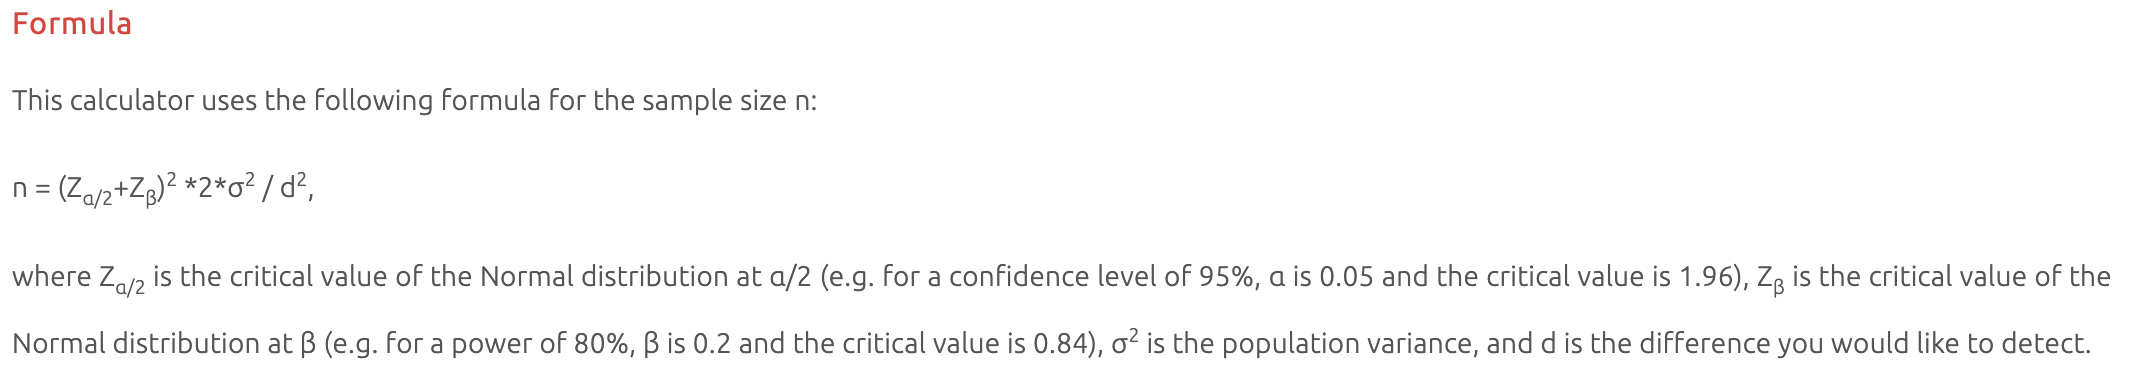

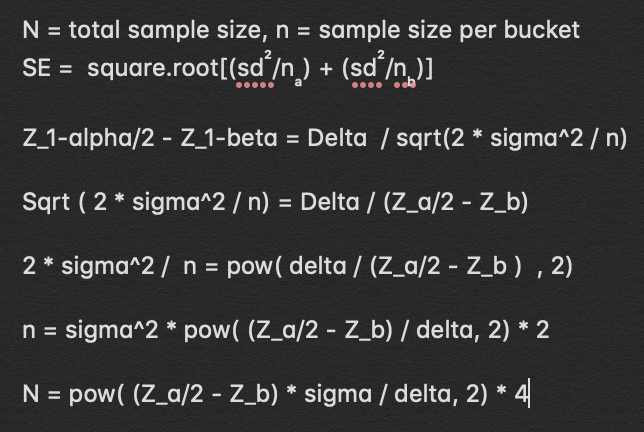

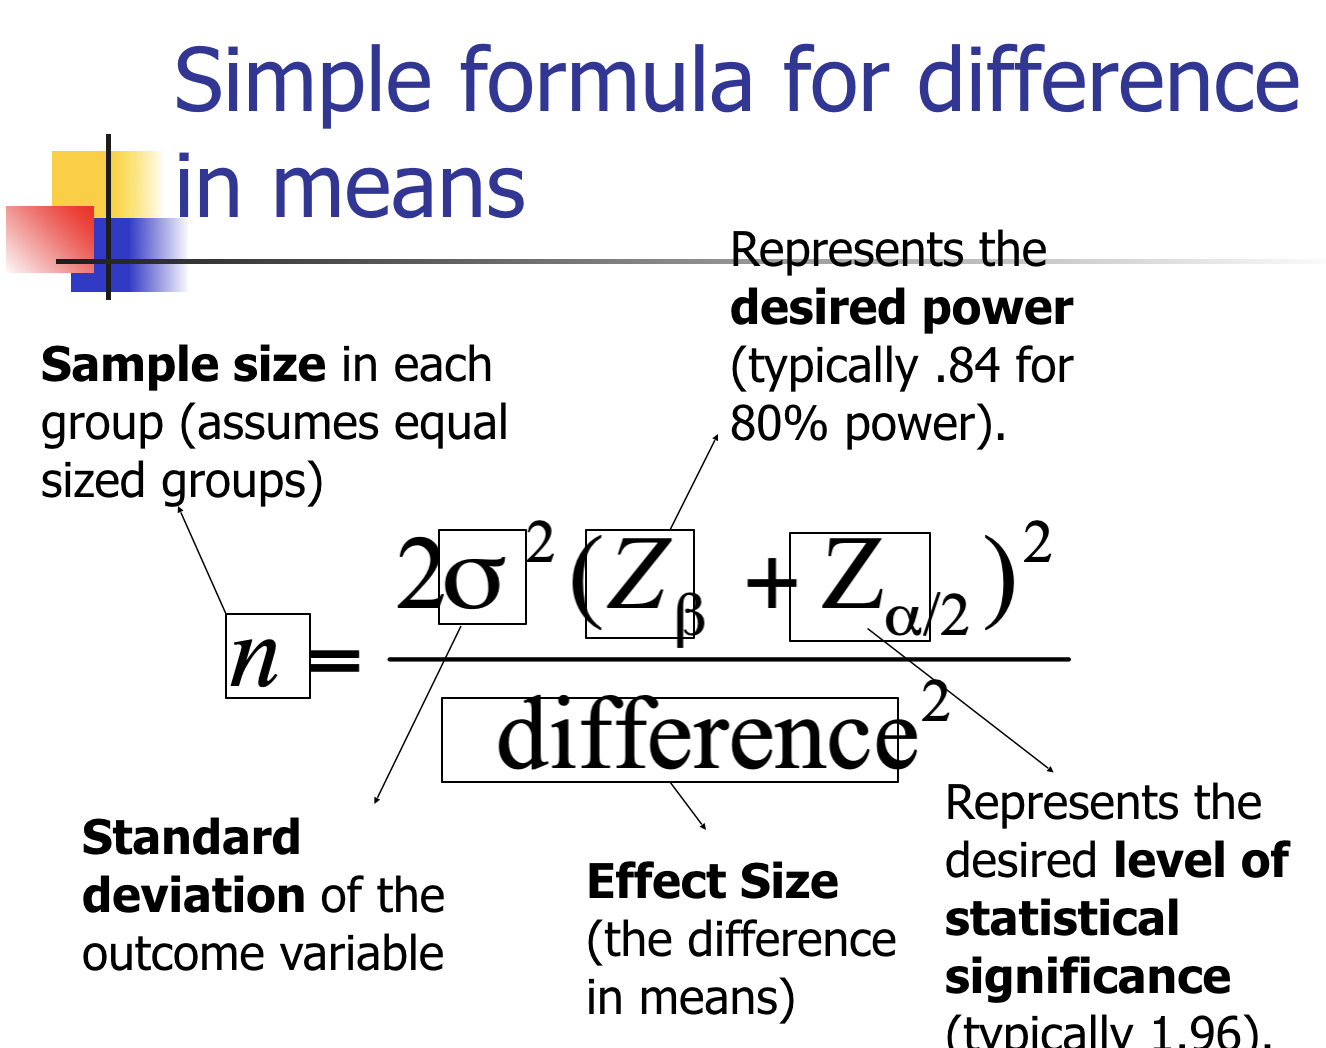

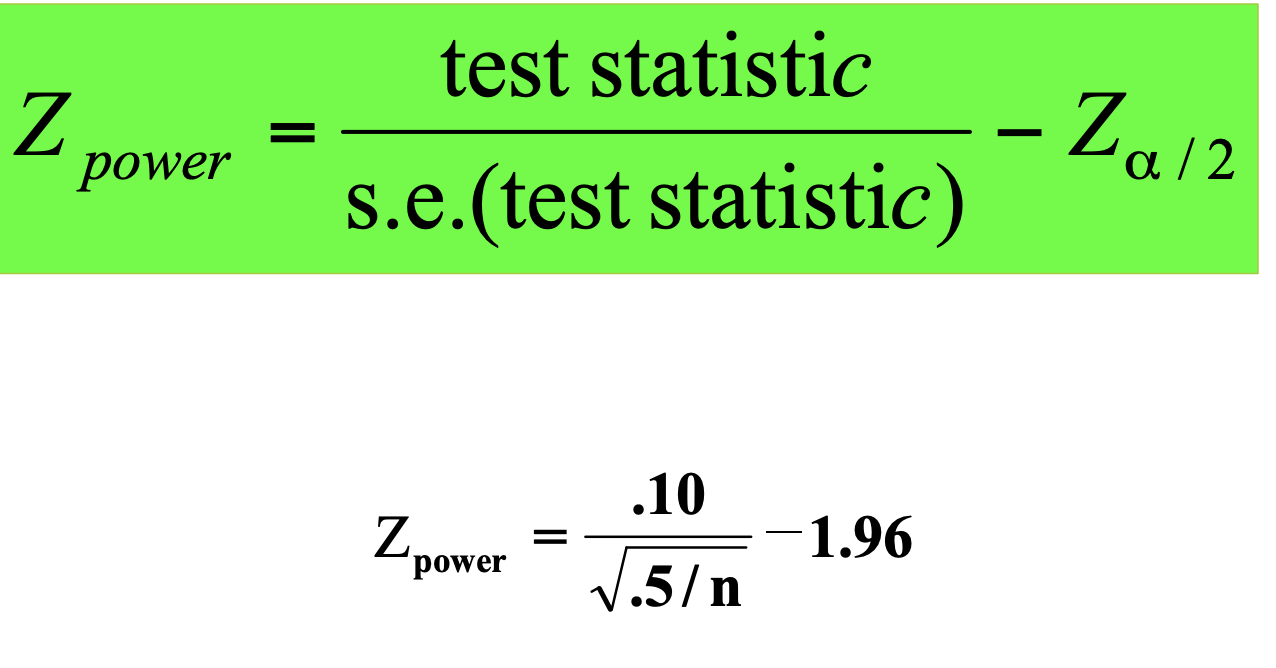

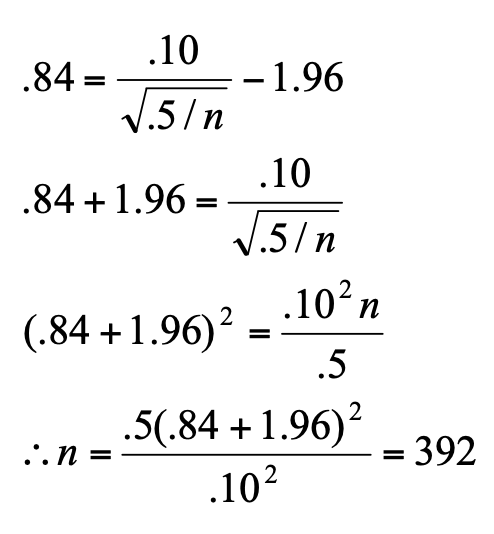

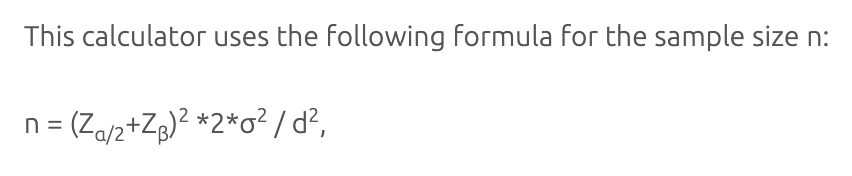

## CUPED

#### Example query

In [ ]:
# q = \
# '''
# with pcli_retailers as (
#   select
#         l.retailer_id as retailer_id
#         , case when l.was_limit_increased = 1 and l.limit_increased_credit_application = 0 then 'proactive limit increased'
#         when l.was_limit_increased = 1 and l.limit_increased_credit_application = 1 then 'application limit increased'
#         when l.was_limit_decreased = 1 then 'proactive limit decreased'
#         else '' end as brand_order_bucket
#         , min(limit_decision_event_created_at) as first_limit_decision_event_created_at
#   from etl.risk_underwriting_limits_change_log l
#   left join production.retailers r
#     on r.id = l.retailer_id
  
#   where brand_order_bucket = 'proactive limit increased'
#     and date_trunc('month', l.limit_decision_event_created_at)::date = '2019-04-01'
#     and r.created_at <= dateadd(day, -89, '2019-04-01')
  
#   group by 1, 2
# )
# , retailer_cm_ltd as (
#   select retailer_id
#     , sum(net_contribution_ex_fees_from_insider_and_opex) as ltd_cm
#     , sum(gmv) as ltd_gmv
#     , sum(fc.returns)/ltd_gmv as return_rate
#     , ltd_cm / ltd_gmv as cm_pct
#   from etl.finance_cm fc
#   where brand_order_created_date <= '04-01-2019'
#   group by 1
# )

# -- define control group: retailers with one net brand order placed in the 90 days preceding 5/16 and have never received a proactive limit increase
# , control as (
#   select
#     bos.retailer_id as retailer_id
#     , max(brand_order_created_date) as latest_brand_order_in_apr
#     , sum(bos.total_gmv_dollars) as gmv
#   from etl.brand_order_summary bos
#   join production.brand_orders bo
#     on bos.brand_order_id = bo.id
#   join retailer_cm_ltd rcl
#     on rcl.retailer_id = bos.retailer_id
#   join production.retailers r
#     on r.id = bos.retailer_id

#   where (brand_order_created_date BETWEEN dateadd(day,-89,'04-01-2019') and '05-01-2019')
#     and bo.payment_term ilike '%NET%'
#     and rcl.return_rate <= 0.10
#     and bos.retailer_id not in
#         (select distinct retailer_id
#         from etl.risk_underwriting_limits_change_log l
#         where l.was_limit_increased = 1 and l.limit_increased_credit_application = 0)
#         and r.created_at <= dateadd(day, -89, '2019-04-01')
#     and rcl.cm_pct >= 0.1
  
#   group by 1
#   having gmv >= (300 * 3)
# )
# select
# bos.retailer_id
# ,sum(case when c.retailer_id is not null and bos.brand_order_created_date between latest_brand_order_in_apr - interval '90 days' and latest_brand_order_in_apr then bos.amount_dollars_ordered else 0 end) as control_pre
# , sum(case when c.retailer_id is not null and bos.brand_order_created_date between latest_brand_order_in_apr and latest_brand_order_in_apr + interval '90 days' then bos.amount_dollars_ordered else 0 end) as control_post
# ,sum(case when pcli.retailer_id is not null and bos.brand_order_created_date between first_limit_decision_event_created_at - interval '90 days' and first_limit_decision_event_created_at then bos.amount_dollars_ordered else 0 end) as increase_pre
# ,sum(case when pcli.retailer_id is not null and bos.brand_order_created_date between first_limit_decision_event_created_at and first_limit_decision_event_created_at + interval '90 days' then bos.amount_dollars_ordered else 0 end) as increase_post
# from etl.brand_order_summary bos
# join etl.finance_cm fc
# on bos.brand_order_id = fc.brand_order_id
# left join control c
# on c.retailer_id = bos.retailer_id
# and date_trunc('month', latest_brand_order_in_apr)::date = '2019-04-01'
# left join pcli_retailers pcli
# on pcli.retailer_id = bos.retailer_id
# where (bos.retailer_id in (select retailer_id from control) OR bos.retailer_id in (select retailer_id from pcli_retailers))
#  by 1
# having control_pre + control_post + increase_pre + increase_post >0
# '''

In [ ]:
df = query_to_raw_df(redshift_postgres_uri, q)

### R Code for CUPED Variance Reduction

In [ ]:
# inputs_limit_increase <- retailers %>%
#   mutate(theta = cov(increase_pre, increase_post) / var(increase_pre),
#          gmv_period_2_cuped = increase_post - (increase_pre - mean(increase_pre)) * theta) %>%
#   mutate_at(c('increase_post', 'gmv_period_2_cuped'), ~ pmin(pmax(., quantile(., .01)), quantile(., .99))) %>%
#   summarise(gmv_period_2_var = var(increase_post),
#             gmv_period_2_var_cuped = var(gmv_period_2_cuped),
#             gmv_period_2_mean = mean(increase_post),
#             gmv_period_2_mean_cuped = mean(gmv_period_2_cuped),
#             var_reduction = gmv_period_2_var_cuped / gmv_period_2_var - 1,
#             order_conversion = mean(increase_post > 0))

# inputs_control <- retailers %>%
#   replace_na(list(control_pre = 0, control_post = 0)) %>%
#   mutate(theta = cov(control_pre, control_post) / var(control_pre),
#          gmv_period_2_cuped = control_post - (control_pre - mean(control_pre)) * theta) %>%
#   mutate_at(c('control_post', 'gmv_period_2_cuped'), ~ pmin(pmax(., quantile(., .01)), quantile(., .99))) %>%
#   summarise(gmv_period_2_var = var(control_post),
#             gmv_period_2_var_cuped = var(gmv_period_2_cuped),
#             gmv_period_2_mean = mean(control_post),
#             gmv_period_2_mean_cuped = mean(gmv_period_2_cuped),
#             var_reduction = gmv_period_2_var_cuped / gmv_period_2_var - 1,
#             order_conversion = mean(control_post > 0))

# get_sample_size <- function(theta_, var_ = NULL, alpha_ = .2, beta_ = .2, ratio_ = 1) {
  
#   Z_alpha <-  qnorm(1 - alpha_ / 2)
#   Z_beta <- qnorm(1 - beta_)
  
#   return(((ratio_ + 1) * ((Z_alpha + Z_beta) ^ 2) * var_) / (ratio_ * theta_ ^ 2))
  
# }

# increse_pct <- 0.15
# # @ alpha = 20, beta = 20
# samples_per_variant <- get_sample_size(
#   inputs_limit_increase$gmv_period_2_mean_cuped * increse_pct,
#   inputs_limit_increase$gmv_period_2_var_cuped,
#   alpha_ = 0.2,
#   beta_ = 0.2)

# samples_per_variant_control <- get_sample_size(
#   inputs_control$gmv_period_2_mean_cuped * increse_pct,
#   inputs_control$gmv_period_2_var_cuped,
#   alpha_ = 0.2,
#   beta_ = 0.2)


# # @ alpha = 10, beta = 10
# samples_per_variant <- get_sample_size(
#   inputs_limit_increase$gmv_period_2_mean_cuped * increse_pct,
#   inputs_limit_increase$gmv_period_2_var_cuped,
#   alpha_ = 0.1,
#   beta_ = 0.1)

# samples_per_variant_control <- get_sample_size(
#   inputs_control$gmv_period_2_mean_cuped * increse_pct,
#   inputs_control$gmv_period_2_var_cuped,
#   alpha_ = 0.1,
#   beta_ = 0.1)

Average CM from etl.finance_cm (excluding opex is 7.3

Standard deviation is 77

## Experimental Setup

- Probably 2 buckets (50, 50) of 2 Insider subscription prices and one of eligible but not offered control
- Running for 2-4 weeks?
- Metric we care most about is CM. However, CM doesn't cure until returns come back. Alternate metrics are
   - Expected CM (impute predicted return rate). Big con is that it's not an empirical number, **therefore not viable**
   - Shipping costs (main source of Insider costs)
   - GMV (lift and order volume matter a lot for future of program)

## Power Analysis

Assumptions (empirically motivated):

**Expect ~15 Insider retailers enrolling per day in each bucket**

**Expect about 5 orders from each retailer in a 1 month period**

Thus, in a month we'll have:

    - About 5 times 15 times 30 / 2 orders = 1125 orders in each bucket
    - But only about 225 retailers in each bucket

**Rough** CM values for Insider (excluding OpEx and subscription):
    - avg = -6%
    - std = 29%
    - median = 2%

**Rough** values for Insider freight per retailer:
    - avg = 9.6%
    - stddev = 16.1%

For alpha = 0.2, Z=1.28

In [ ]:
variance_reduction = 0.3
lift = 0.0

In [ ]:
Z = 1.96
sigma = (1.0-variance_reduction)*math.sqrt(2)*0.12
delta_CM = 0.02
beta = 0.2

In [ ]:
norm.ppf(beta, loc=0, scale=1)

In [ ]:
min_sample_size = pow( (Z - norm.ppf(beta, loc=0) )/((delta_CM)/sigma ), 2)
print(min_sample_size)

In [ ]:
sample_size=400

In [ ]:
mean_diff = []
for i in range(5000):
    norm_c = pd.Series(np.random.normal(loc=0.046, scale=0.084, size=sample_size))
    norm_t = pd.Series(np.random.normal(loc=0.02, scale=0.084, size=sample_size))
    mean_diff.append(norm_t.mean() - norm_c.mean())

In [ ]:
pd.Series(mean_diff).hist(bins=50)

In [ ]:
np.percentile(mean_diff, 20)

In [ ]:
400/9

### Using retailer CM

In [ ]:
variance_reduction = 0.3
sigma = (1.0-variance_reduction) * math.sqrt(2)*29 

In [ ]:
Z = 1.28
mu_c = 0
mu_t = 2.7
beta = 0.8

In [ ]:
norm.ppf(1-beta, loc=0, scale=1)

In [ ]:
Z - norm.ppf(0.2)

In [ ]:
min_sample_size = pow( (Z - norm.ppf(1.0-beta) )/((mu_c - mu_t)/sigma ), 2)
print(min_sample_size)

In [ ]:
ordering_retailers_per_day = 15*1

In [ ]:
n_days = min_sample_size / ordering_retailers_per_day

print(n_days)

Variance reduction of 0.5

In [ ]:
variance_reduction = 0.5
sigma = (1.0-variance_reduction) * math.sqrt(2)*29 

In [ ]:
Z = 1.28
mu_c = 0
mu_t = 2.7
beta = 0.8

In [ ]:
norm.ppf(1-beta, loc=0, scale=1)

In [ ]:
Z - norm.ppf(0.2)

In [ ]:
min_sample_size = pow( (Z - norm.ppf(1.0-beta) )/((mu_c - mu_t)/sigma ), 2)
print(min_sample_size)

In [ ]:
ordering_retailers_per_day = 15*11

In [ ]:
n_days = min_sample_size / ordering_retailers_per_day

print(n_days)

### Using retailer total_shipping_cost_dollars / gmv

In [ ]:
q = \
'''
  SELECT 
        bos.retailer_id
      , SUM(bos.total_shipping_cost_dollars)::FLOAT / SUM(bos.total_gmv_dollars) as shipping_cost_fraction
  FROM etl.brand_order_summary bos
  
  WHERE bos.brand_order_created_date between '2019-03-01' and '2019-08-01'
  group by 1
'''

In [ ]:
df = query_to_raw_df(redshift_postgres_uri, q)

In [ ]:
df.head()

In [ ]:
df = df.loc[df['shipping_cost_fraction']<1, :]
print(df['shipping_cost_fraction'].mean())
df['shipping_cost_fraction'].hist(bins=100);
plt.xlim(0, 0.4);

In [ ]:
df = df.loc[df['shipping_cost_fraction']<1, :]
print((df['shipping_cost_fraction'] -0.02).mean())
(df['shipping_cost_fraction'] -0.02).hist(bins=100);
plt.xlim(0, 0.4);

Without vaiance reduction:

In [ ]:
Z = 1.28
sigma = math.sqrt(2)*16.1
mu_c = 9.6
mu_t = 6.7
beta = 0.8

In [ ]:
norm.ppf(1-beta, loc=0, scale=1)

In [ ]:
Z - norm.ppf(0.2)

In [ ]:
min_sample_size = pow( (Z - norm.ppf(1.0-beta) )/((mu_c - mu_t)/sigma ), 2)
print(min_sample_size)

In [ ]:
ordering_retailers_per_day = 15

In [ ]:
print(ordering_retailers_per_day)

In [ ]:
n_days = min_sample_size / ordering_retailers_per_day

print(n_days)

# What metric do we care about?

- Cash in? (GMV*commission-shipping_cost)
- Actual CM minus return rate
- Shipping cost

Daniel: rough guess of 50% reduction in variance

# Comparing Enrolled versus Control?

### Initial expectation:

The above should be close to sufficient to compute a change in Insider Freight change from -7.7% to -5.6% at alpha=0.20 and power=0.80, **if the standard error of the freight costs mean difference stayed the same, i.e. was purely statistical**

The sample size is 810, which if we test on an order level, is close to what we'll have in 30 days

## Caveats and missing considerations

- Model also sorts by expected return rate, which is not well predicted, 
- How safe are we to enrollment fluctuations. What's the expected enrollment dip/lift at 19.99?

In [ ]:
variance_reduction = 0.5
lift = 0.2

In [ ]:
Z = 1.28
sigma = (1.0 - variance_reduction) * math.sqrt(2)*280 
mu_c = 38
mu_t = (1.0+lift)*mu_c
beta = 0.2

In [ ]:
min_sample_size = pow( (Z - norm.ppf(beta) )/((mu_c - mu_t)/sigma ), 2)
print(min_sample_size)

In [ ]:
ordering_retailers_per_day = 600

In [ ]:
print(ordering_retailers_per_day)

In [ ]:
n_days = min_sample_size / ordering_retailers_per_day
print(n_days)

## FS Carousels

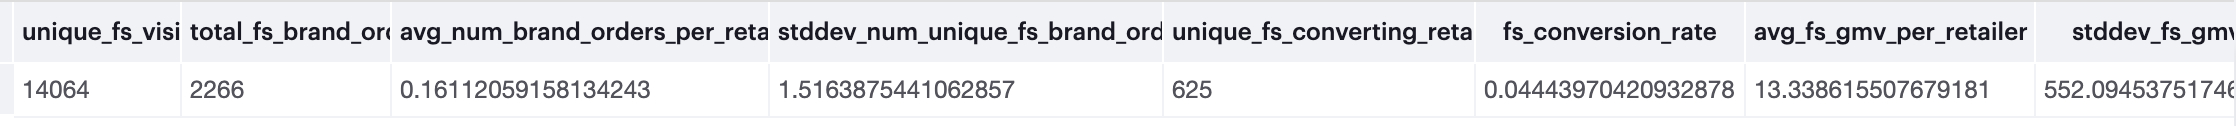

#### gmv per retailerr

In [ ]:
variance_reduction = 0.3
lift = 0.20

In [ ]:
Z = 1.28
SE = (1.0 - variance_reduction) * math.sqrt(2)*sigma
mu_c = 13.3
mu_t = (1+lift)*mu_c
beta = 0.8

In [ ]:
min_sample_size = pow( (Z - norm.ppf(1.0-beta) )/((mu_c - mu_t)/sigma ), 2)
print(min_sample_size)

In [ ]:
visiting_retailers_per_day = 500

In [ ]:
print(visiting_retailers_per_day)

In [ ]:
n_days = min_sample_size / visiting_retailers_per_day
print(n_days)

### FS orders per retailer

In [ ]:
variance_reduction = 0.3
lift = 0.045

In [ ]:
Z = 1.28
sigma = (1.0 - variance_reduction) * math.sqrt(2)*1.51
mu_c = 0.16
mu_t = (1+lift)*mu_c
beta = 0.8

In [ ]:
min_sample_size = pow( (Z - norm.ppf(1.0-beta) )/((mu_c - mu_t)/sigma ), 2)
print(min_sample_size)

*in each bucket*

2 buckets so divide by two

In [ ]:
visiting_retailers_per_day = 500/2

In [ ]:
print(visiting_retailers_per_day)

In [ ]:
n_days = min_sample_size / visiting_retailers_per_day
print(n_days)

## FS Carousels  v2 (makers you love only)

Past 4 weeks of data

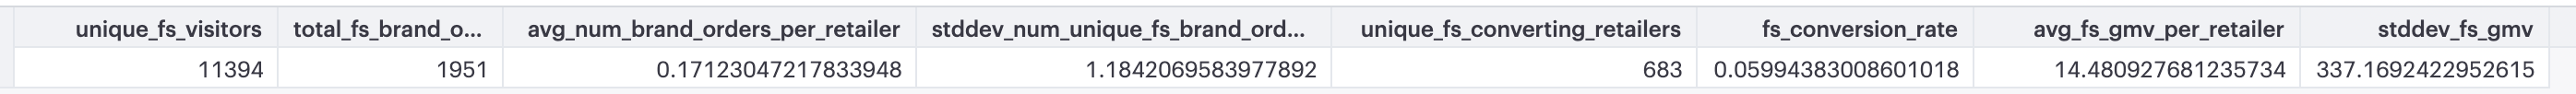

#### gmv per retailerr

In [ ]:
variance_reduction = 0.15
lift = 0.05

In [ ]:
Z = 1.28
sigma = 337.2
SE = (1.0 - variance_reduction) * math.sqrt(2)*sigma
mu_c = 14.5
mu_t = (1+lift)*mu_c
beta = 0.8

In [ ]:
min_sample_size = pow( (Z - norm.ppf(1.0-beta) )/((mu_c - mu_t)/sigma ), 2)
print(min_sample_size)

In [ ]:
visiting_retailers_per_day = 500

In [ ]:
print(visiting_retailers_per_day)

In [ ]:
n_days = min_sample_size / visiting_retailers_per_day
print(n_days)

### FS retailer conversion

In [ ]:
lift = 0.07

In [ ]:
n_weeks = 7

In [ ]:
11394/4*n_weeks

In [ ]:
n_successes_per_bucket = n_weeks*int(683/4/2)
n_trials_per_bucket = n_weeks*int(11394/4/2)

In [ ]:
count = np.array([(1 + lift) * n_successes_per_bucket, n_successes_per_bucket])
nobs = np.array([n_trials_per_bucket, n_trials_per_bucket])
stat, pval = proportions_ztest(count, nobs)

print('{0:0.3f}'.format(pval))
print('{0:0.3f}'.format(stat))

### FS breakdown proportion test

In [ ]:
n_successes_per_bucket = n_weeks*int(683/4/2)
n_trials_per_bucket = n_weeks*int(11394/4/2)

count = np.array([(1 + lift) * n_successes_per_bucket, n_successes_per_bucket])
nobs = np.array([n_trials_per_bucket, n_trials_per_bucket])
stat, pval = proportions_ztest(count, nobs)

print('{0:0.3f}'.format(pval))
print('{0:0.3f}'.format(stat))

# Testing normality

In [ ]:
sample_size = 10000

In [ ]:
exp_c = pd.Series(np.random.exponential(0.009, size=sample_size))

In [ ]:
exp_c.mean()

In [ ]:
exp_c.hist(bins=100)

In [ ]:
exp_t = pd.Series(np.random.exponential(0.010, size=sample_size))

In [ ]:
exp_t.mean()

In [ ]:
exp_t.hist(bins=100)

In [ ]:
mean_diff = []
for i in range(10000):
    exp_c = pd.Series(np.random.exponential(0.009, size=sample_size))
    exp_t = pd.Series(np.random.exponential(0.010, size=sample_size))
    mean_diff.append(exp_c.mean() - exp_t.mean())

In [ ]:
pd.Series(mean_diff).hist(bins=100)

So normality works if the underlying distribution is truly an exponential decay matching the rate

### But what if it's truly a Bernoulli process? 

In [ ]:
sample_size=5000

In [ ]:
print(sample_size)

In [ ]:
mean_diff = []
for i in range(20000):
    bin_c = pd.Series(np.random.binomial(1, 0.044, size=sample_size))
    bin_t = pd.Series(np.random.binomial(1, 1.2*0.044, size=sample_size))
    mean_diff.append(bin_c.mean() - bin_t.mean())

In [ ]:
pd.Series(mean_diff).hist(bins=200)

### Volume-based discounts M&M
Query has 4 weeks worth of data

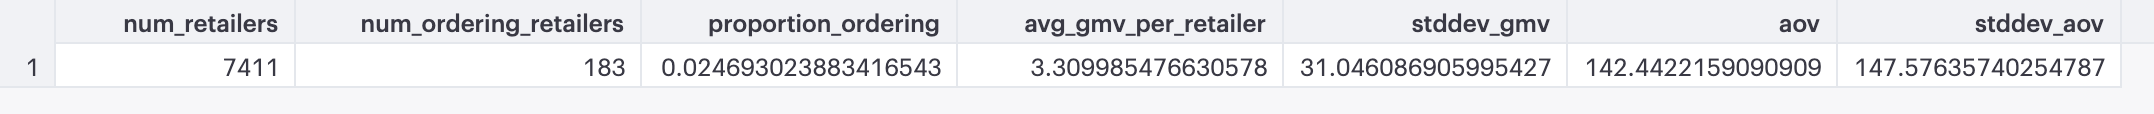

In [ ]:
daily_visit_rate = 7411/28
print(daily_visit_rate)

In [ ]:
daily_order_rate = 183/28
print(daily_order_rate)

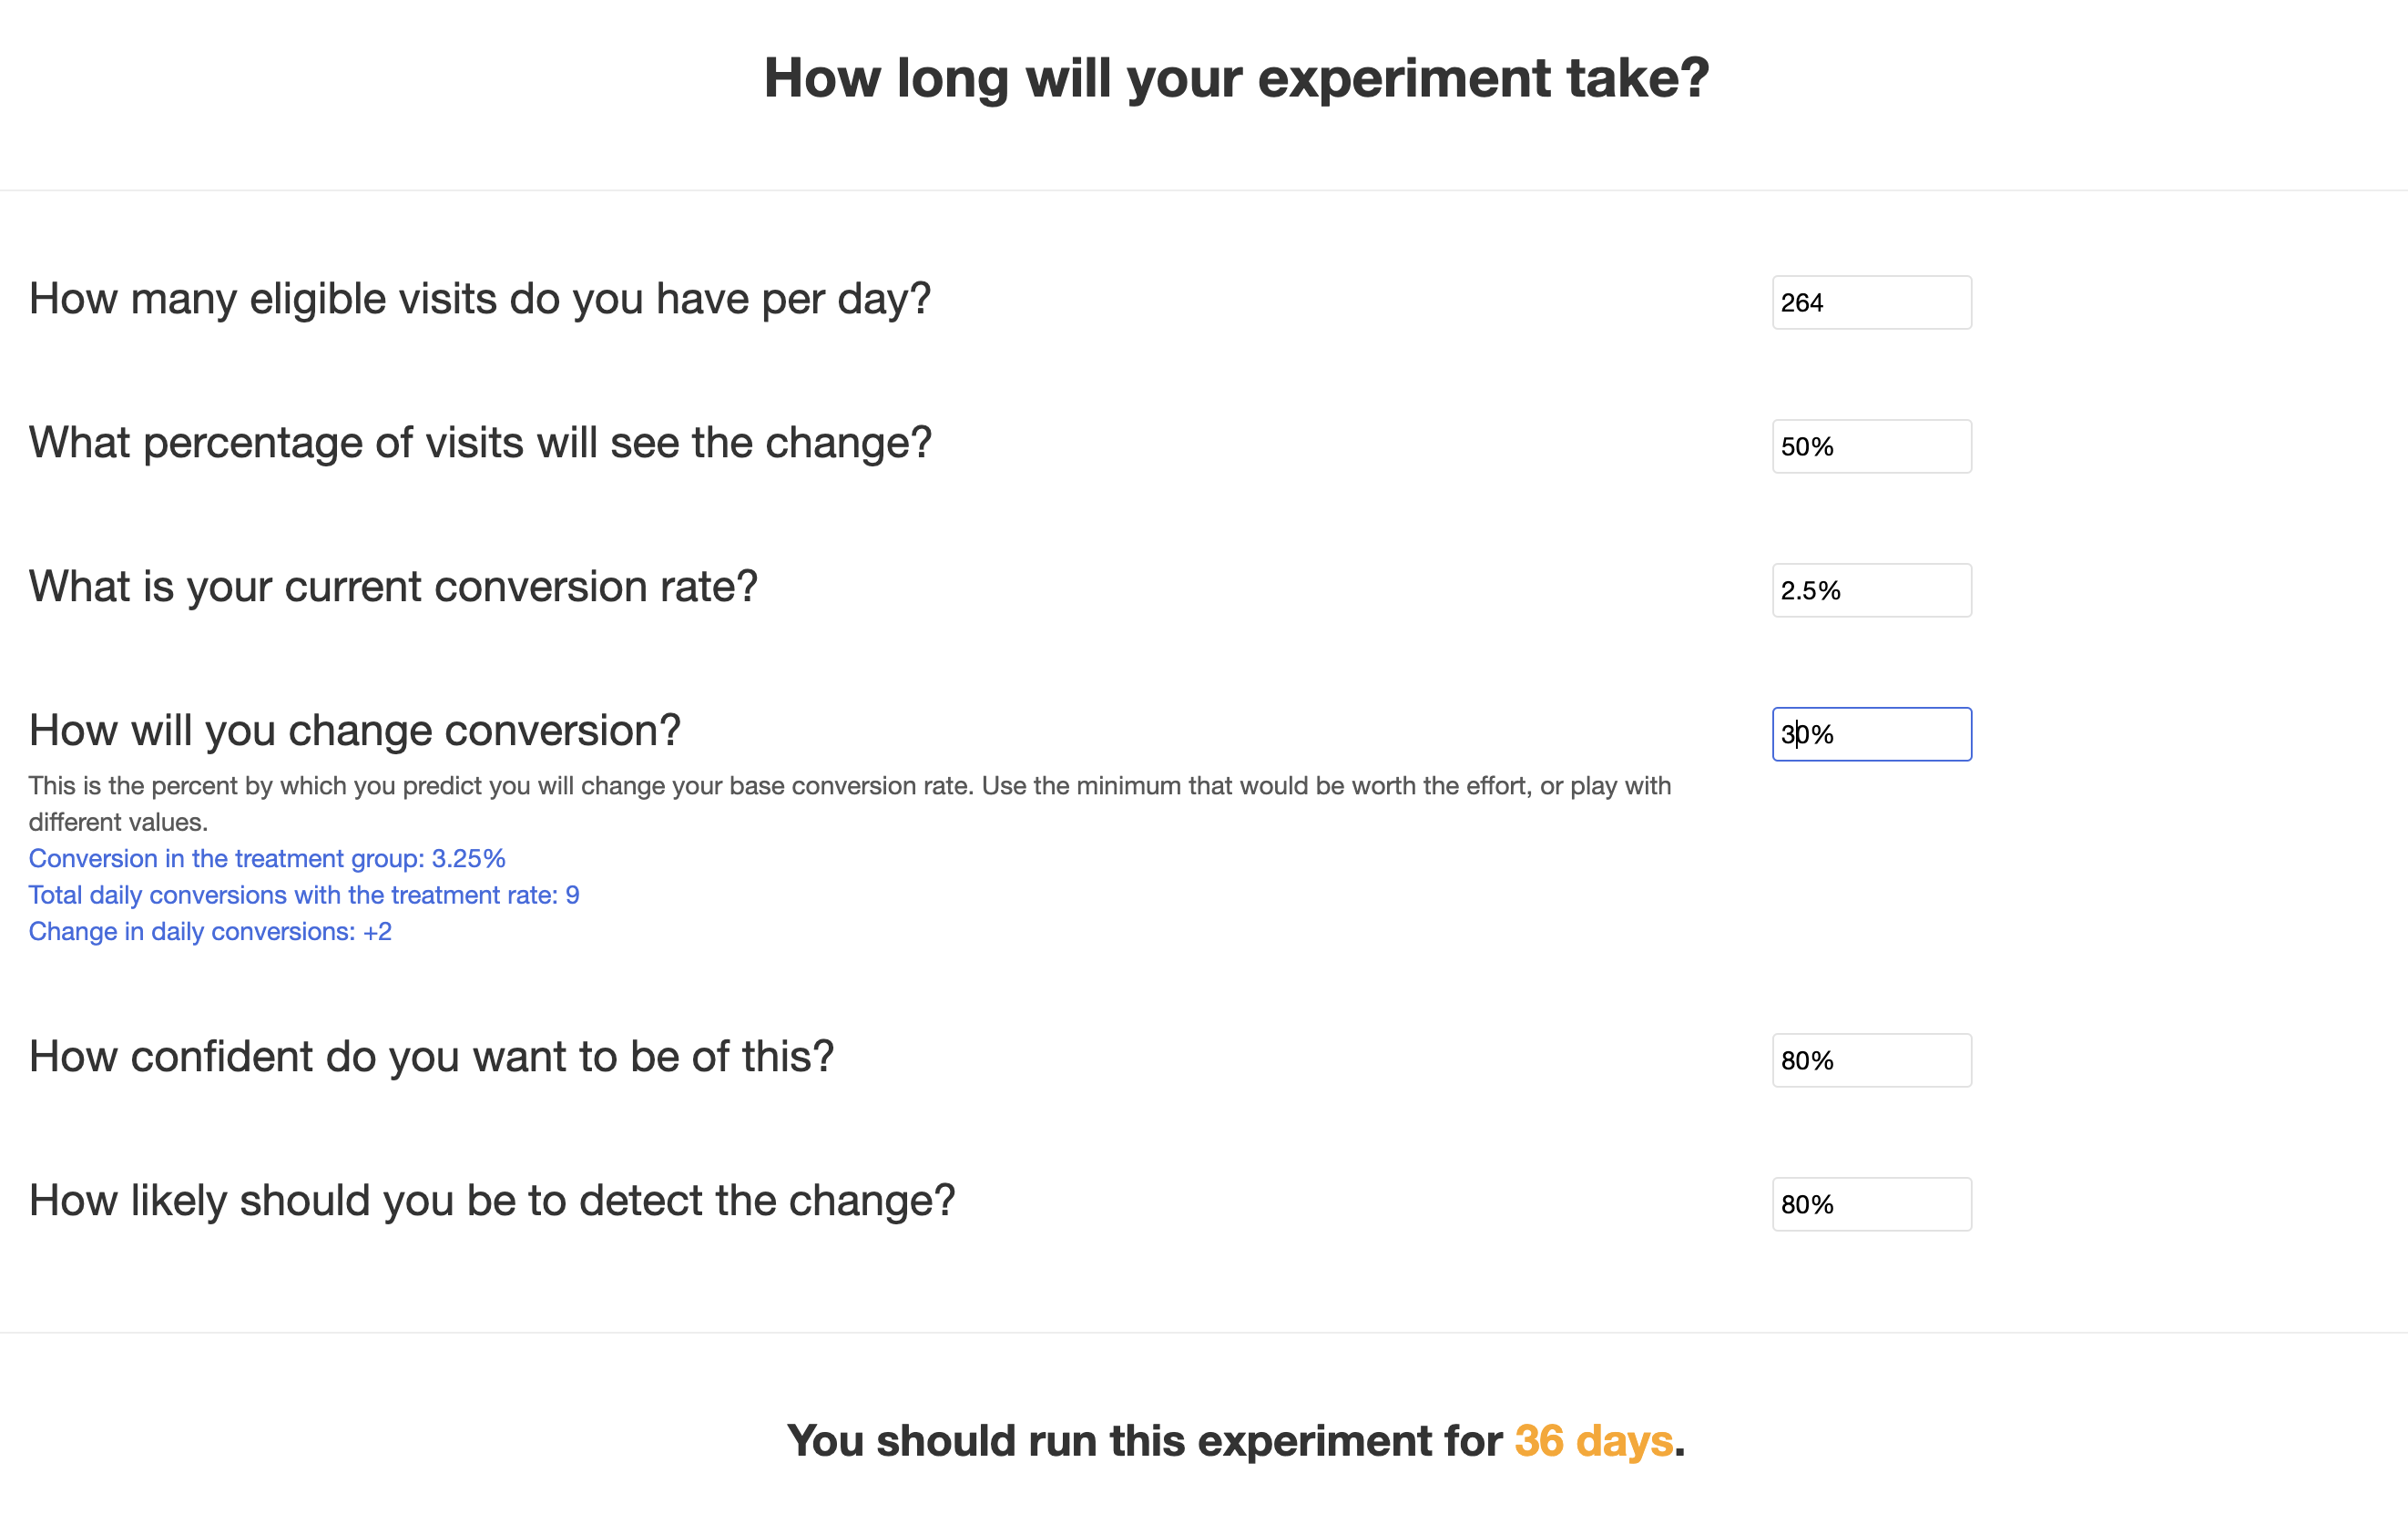

In [ ]:
import math

In [ ]:
variance_reduction = 0.25

lift = 0.15
mu = 12.3
std = 404

In [ ]:
Z = 1.28
sigma = (1.0-variance_reduction)*math.sqrt(2)*std
delta = mu*lift
beta = 0.2

In [ ]:
norm.ppf(beta, loc=0, scale=1)

min_sample_size = pow( (Z - norm.ppf(beta, loc=0) )/(delta/sigma), 2)
print(min_sample_size)

In [ ]:
daily_rate = 540

In [ ]:
print(min_sample_size / daily_rate)

## TOST

In [ ]:
from statsmodels.stats.weightstats import ttost_ind
from statsmodels.stats.proportion import proportion_confint

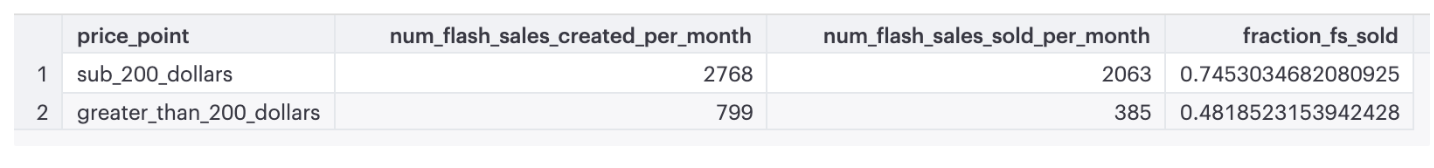

In [ ]:
mean = 0.745
nobs_c = 2768
count_c = 2063

# Divided by two because we'll keep some unbroken down flagged collections for sanity checks and comparisons
nobs_t = int(799 / 2.0)
count_t = int(385 / 2.0)

upper = 0.125
lower = -0.125

In [ ]:
unc_c = proportion_confint(count=count_c, nobs=nobs_c, method='wilson')

In [ ]:
unc_c = mean - unc_c[0]

In [ ]:
unc_t = proportion_confint(count=count_t, nobs=nobs_t, method='wilson')

In [ ]:
unc_t = mean - unc_t[0]

In [ ]:
daily_rate = nobs_t/28

In [ ]:
variance_reduction = 0.

lift = 0.5*(0.745 - 0.481)/0.481
mu = 0.481
std = unc_t

Z = 1.28
sigma = (1.0-variance_reduction)*math.sqrt(2)*std
delta = mu*lift
beta = 0.2

norm.ppf(beta, loc=0, scale=1)

min_sample_size = pow( (Z - norm.ppf(beta, loc=0) )/(delta/sigma), 2)
print(min_sample_size)

print(min_sample_size / daily_rate)

In [ ]:
sample_size=400

mean_diff = []
for i in range(50):
    
    data_c = np.random.binomial(n=nobs_c, p=mean, size=sample_size)
    data_t = np.random.binomial(n=nobs_t, p=mean-0.5, size=sample_size)
    
    test = ttost_ind(data_c, data_t, lower, upper)
    
    print(test)
    
#     mean_c = pd.Series(np.random.normal(loc=0.745, scale=unc_c, size=sample_size))
#     mean_t = pd.Series(np.random.normal(loc=0.745, scale=unc_t, size=sample_size))
    
#     mean_diff.append(norm_t.mean() - norm_c.mean())

# pd.Series(mean_diff).hist(bins=50)

# np.percentile(mean_diff, 20)

In [ ]:
test.

## Improving Credit Limit Communication

For every retailer that is eligible to be on net terms, we will clarify the copy on the exposed cart. Every retailer that is eligible that visits a brand will potentially be bucketed.

Primary metric GMV/retailer

Expected lift in GMV/retailer ~5%

Also care whether this will change the proportion of net terms vs payment on shipment.

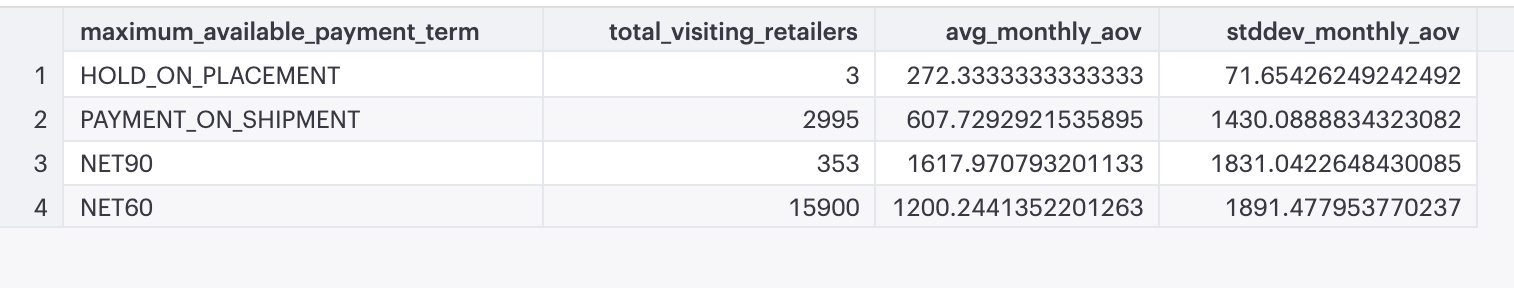

#### gmv per retailerr

In [ ]:
variance_reduction = 0.2
lift = 0.05

In [ ]:
Z = 1.28  # 80% CL
std_dev = 1891.5
std_error = (1.0 - variance_reduction) * math.sqrt(2)*std_dev 
mu_c = 1200 * 0.7
mu_t = (1+lift)*mu_c
beta = 0.8

In [ ]:
min_sample_size = pow( (Z - norm.ppf(1.0-beta) )/((mu_c - mu_t)/std_error ), 2)

In [ ]:
print(min_sample_size)

In [ ]:
visiting_retailers_per_day = 0.8*15900/28

In [ ]:
print(visiting_retailers_per_day)

In [ ]:
n_days = min_sample_size / visiting_retailers_per_day
print(n_days)

## Insider eligibility

#### gmv per retailerr

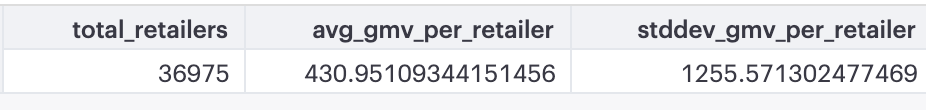

In [ ]:
variance_reduction = 0.25
lift = 0.10

In [ ]:
Z = 1.28
mu_c = 430.951
mu_t = (1+lift)*mu_c
stddev = 1255.6
sigma = (1.0 - variance_reduction) * math.sqrt(2)*stddev
beta = 0.8

In [ ]:
visiting_retailers_per_day = 500

In [ ]:
sample_size = 8000

In [ ]:
sample_size/visiting_retailers_per_day

In [ ]:
mean_diff = []
for i in range(15000):
    bin_c = pd.Series(np.random.normal(loc = mu_c, scale=sigma, size=int(0.1*sample_size)))
    bin_t = pd.Series(np.random.normal(loc = 1.1*mu_c, scale=sigma, size=int(0.9*sample_size)))
    mean_diff.append(bin_t.mean() - bin_c.mean())

In [ ]:
pd.Series(mean_diff).hist(bins=200)

In [ ]:
np.percentile(mean_diff, 20)

### Category Banner for M&M

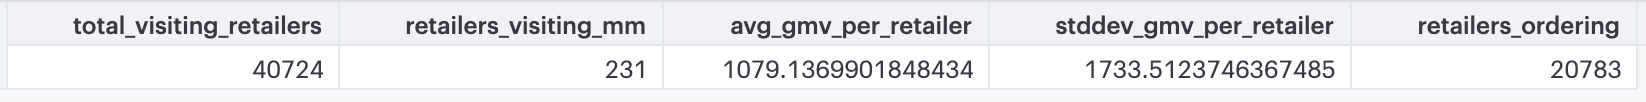

### Defensive GMV/retailer

In [ ]:
variance_reduction = 0.2
lift = -0.025

In [ ]:
Z = 1.28  # 80% CL
std_dev = 1378.7
std_error = (1.0 - variance_reduction) * math.sqrt(2)*std_dev 
mu_c = 894
mu_t = (1+lift)*mu_c
beta = 0.8

In [ ]:
min_sample_size = pow( (Z - norm.ppf(1.0-beta) )/((mu_c - mu_t)/std_error ), 2)

In [ ]:
print(min_sample_size)

In [ ]:
visiting_retailers_per_day = 0.8* 40724 / 2 / 28

In [ ]:
print(visiting_retailers_per_day)

In [ ]:
n_days = min_sample_size / visiting_retailers_per_day
print(n_days)

### Test non-returnability in the "long-term"

The retailers that visit M&M may have a 2.5% drop in GMV or a drop in their order conversion

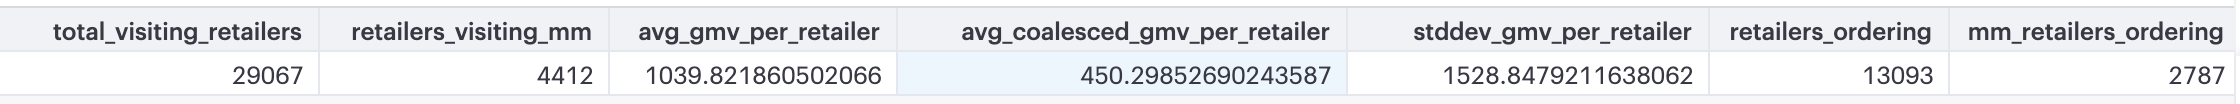

M&M visitor order conversion (non-internal brands)

In [ ]:
2787/4412

Non-M&M visitor order conversion (non-internal brands):

In [ ]:
13093/29067

Visitors that also visit M&M:

In [ ]:
4412/29067

Visitors per day:

In [ ]:
4412/28

In [ ]:
variance_reduction = 0.2
lift = -0.025

In [ ]:
Z = 1.28  # 80% CL
std_dev = 1528.8
std_error = (1.0 - variance_reduction) * math.sqrt(2)*std_dev 
mu_c = 894
mu_t = (1+lift)*mu_c
beta = 0.8

In [ ]:
min_sample_size = pow( (Z - norm.ppf(1.0-beta) )/((mu_c - mu_t)/std_error ), 2)

In [ ]:
print(min_sample_size)

In [ ]:
visiting_retailers_per_day = 0.8* 40724 / 2 / 28

In [ ]:
print(visiting_retailers_per_day)

In [ ]:
n_days = min_sample_size / visiting_retailers_per_day
print(n_days)

## FS Clearance channel

https://select-statistics.co.uk/calculators/sample-size-calculator-two-means/

#### gmv per retailer

In [92]:
variance_reduction = 0.1
lift = 0.1

In [93]:
pre_sigma = 315.6
sigma = (1.0 - variance_reduction) * pre_sigma
mu_c = 18.8
mu_t = (1+lift)*mu_c
alpha = 0.2
beta = 0.8

In [94]:
min_sample_size = pow( (norm.ppf(1-alpha/2) - norm.ppf(1-beta) ) * sigma / (mu_c - mu_t), 2)
print(min_sample_size)

102899.67253310874


In [95]:
visiting_retailers_per_day = 13157/28

In [96]:
print(visiting_retailers_per_day)

469.89285714285717


In [97]:
n_days = min_sample_size / visiting_retailers_per_day
print(n_days)

218.98539415725807


#### Using ztest

In [57]:
num_tests = 2000
ztest_outcomes = []

for nt in range(num_tests):
    x_control = np.random.normal(mu_c, sigma, int(visiting_retailers_per_day*270 ) )
    x_treatment = np.random.normal((1+lift)*mu_c, sigma, int(visiting_retailers_per_day*270 ))
    ztest_outcomes.append( ztest(x_control, x_treatment)[1] )

In [58]:
np.sum([1 if x < 0.2  else 0 for x in ztest_outcomes]) / len(ztest_outcomes)

0.597

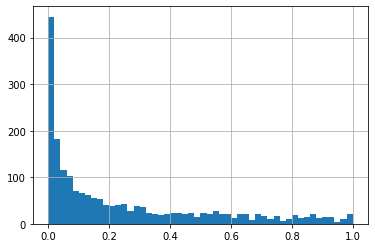

In [59]:
pd.Series(ztest_outcomes).hist(bins=50)

#### gmv per retailer (NO OUTLIERS)

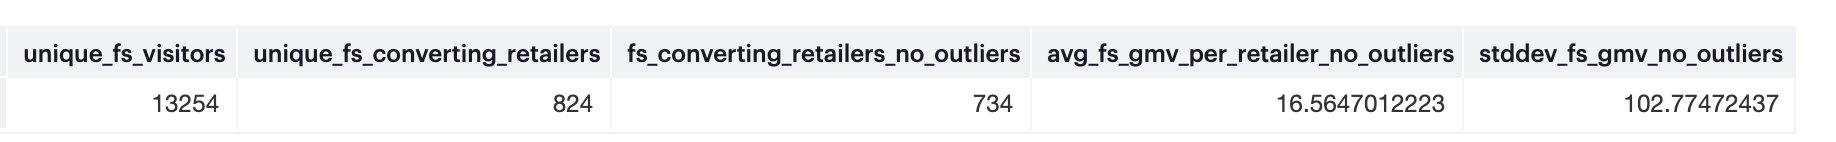

In [119]:
variance_reduction = 0.1
lift = 0.07

In [120]:
pre_sigma = 102
sigma = (1.0 - variance_reduction) * pre_sigma
mu_c = 16.6
mu_t = (1+lift)*mu_c
alpha = 0.2
beta = 0.8

In [121]:
norm.ppf(0.05)

-1.6448536269514729

In [122]:
min_sample_size = pow( (norm.ppf(1-alpha/2) - norm.ppf(1-beta) ) * sigma / (mu_c - mu_t), 2)
print(min_sample_size)

28134.79723232532


In [123]:
visiting_retailers_per_day = 13157/28

In [124]:
print(visiting_retailers_per_day)

469.89285714285717


In [125]:
n_days = min_sample_size / visiting_retailers_per_day
print(n_days)

59.87492000494861


#### gmv per ordering retailer

In [126]:
variance_reduction = 0.1
lift = 0.1

In [127]:
pre_sigma = 853.7
sigma = (1.0 - variance_reduction) * pre_sigma * math.sqrt(2)
mu_c = 315.6
mu_t = (1+lift)*mu_c
alpha = 0.2
beta = 0.8

In [128]:
min_sample_size = pow( (norm.ppf(1-alpha/2) - norm.ppf(1-beta) ) * sigma / (mu_c - mu_t), 2)
print(min_sample_size)

5343.4564177882285


In [130]:
ordering_retailers_per_day = 824/28

In [131]:
print(ordering_retailers_per_day)

29.428571428571427


In [132]:
n_days = min_sample_size / ordering_retailers_per_day
print(n_days)

181.5737617695029


#### gmv per ordering retailer (NO OUTLIERS)

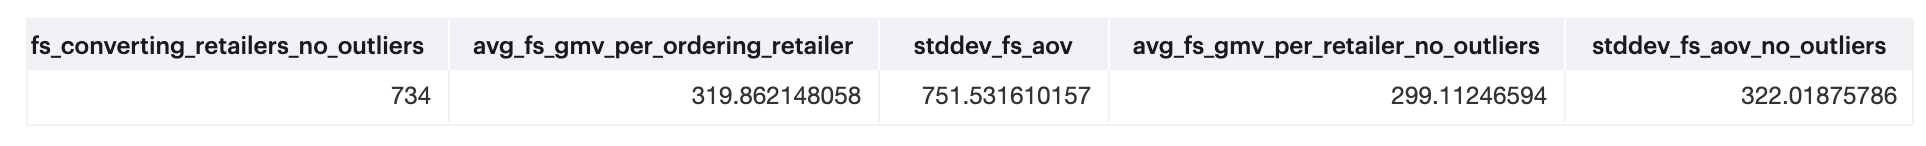

In [133]:
variance_reduction = 0.1
lift = 0.1

In [134]:
pre_sigma = 322
sigma = (1.0 - variance_reduction) * pre_sigma * math.sqrt(2)
mu_c = 299
mu_t = (1+lift)*mu_c
alpha = 0.2
beta = 0.8

In [135]:
min_sample_size = pow( (norm.ppf(1-alpha/2) - norm.ppf(1-beta) ) * sigma / (mu_c - mu_t), 2)
print(min_sample_size)

846.9447192836775


In [136]:
ordering_retailers_per_day = 734/28

In [137]:
print(ordering_retailers_per_day)

26.214285714285715


In [138]:
n_days = min_sample_size / ordering_retailers_per_day
print(n_days)

32.30851790182966


### FS retailer conversion

In [139]:
lift = 0.1

In [144]:
n_weeks = 3

In [145]:
13157/4*n_weeks

9867.75

In [146]:
n_successes_per_bucket = n_weeks*int(785/4/2)
n_trials_per_bucket = n_weeks*int(13157/4/2)

In [147]:
count = np.array([(1 + lift) * n_successes_per_bucket, n_successes_per_bucket])
nobs = np.array([n_trials_per_bucket, n_trials_per_bucket])
stat, pval = proportions_ztest(count, nobs)

print('{0:0.3f}'.format(pval))
print('{0:0.3f}'.format(stat))

0.222
1.222


# Markdown Allowance PA

This is full returned GMV. The actual loss_on_returns coefficient is in the 0.4 to 0.6 range

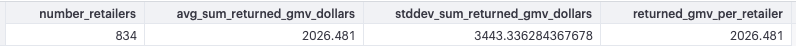

In [87]:
loss_on_returns_coef = 0.5

In [88]:
variance_reduction = 0

In [89]:
lift = -0.142

In [90]:
pre_sigma = 3443.33 * loss_on_returns_coef
sigma = (1.0 - variance_reduction) * pre_sigma * math.sqrt(2)
mu_c = 2026.48 * loss_on_returns_coef
mu_t = (1+lift)*mu_c
alpha = 0.2
beta = 0.8

In [91]:
min_sample_size = pow( (norm.ppf(1-alpha/2) - norm.ppf(1-beta) ) * sigma / (mu_c - mu_t), 2)
print(min_sample_size)

1290.9120035022993


In [92]:
returning_retailers_per_day = 834/56

In [93]:
print(returning_retailers_per_day)

14.892857142857142


In [94]:
n_days = min_sample_size / returning_retailers_per_day
print(n_days)

86.67994268120955
